In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [2]:
%matplotlib inline

In [3]:
# 1. Fetch stock price of PEP and KO
tickers = ["PEP", "KO"]
data = yf.download(tickers, start="2020-01-01", end="2025-01-01", interval='1d')

[*********************100%***********************]  2 of 2 completed


In [4]:
data

Price           Close                   High                    Low  \
Ticker             KO         PEP         KO         PEP         KO   
Date                                                                  
2020-01-02  45.745106  113.114006  46.111132  114.288277  45.553770   
2020-01-03  45.495544  112.955780  45.745111  113.921845  44.996417   
2020-01-06  45.478897  113.388847  45.678550  113.530438  45.354117   
2020-01-07  45.129517  111.606636  45.420674  113.322263  45.046330   
2020-01-08  45.212688  112.181236  45.453934  112.730902  45.046315   
...               ...         ...        ...         ...        ...   
2024-12-24  61.039143  146.938126  61.039143  146.957361  60.232927   
2024-12-26  60.776878  146.582367  60.942008  147.293922  60.611752   
2024-12-27  60.660320  147.015076  61.145991  147.572790  60.427197   
2024-12-30  60.252354  145.890045  60.553471  147.207397  59.912385   
2024-12-31  60.475761  146.216949  60.640892  147.265062  60.028945   

Price                        Open                Volume           
Ticker             PEP         KO         PEP        KO      PEP  
Date                                                              
2020-01-02  112.547680  46.019625  113.988460  11867700  3784100  
2020-01-03  112.539369  45.187750  112.814202  11354500  4000100  
2020-01-06  112.597668  45.462262  112.680955  14698300  4085100  
2020-01-07  111.556669  45.295893  113.263959   9973900  5718100  
2020-01-08  111.656567  45.146140  111.981367  10676000  3681400  
...                ...        ...         ...       ...      ...  
2024-12-24  144.630354  60.417484  144.716892   5019100  3399800  
2024-12-26  146.390055  60.825445  146.668905   7943800  5528500  
2024-12-27  145.447705  60.660320  145.476551   8542800  4287000  
2024-12-30  145.284249  60.553471  146.793927   8972200  5397000  
2024-12-31  145.139991  60.242641  145.966945   9256700  4274800  

[1258 rows x 10 columns]

In [5]:
# 2. Log price
# Log(S1/S2) = ratio of returns
S1 = np.log(data["Close"]['PEP'])
S2 = np.log(data["Close"]["KO"])

In [6]:
# 3. Calculate the Hedge ratio by OLS
# PEP = beta * KO + alpha + residual
# residual is the spread we need here
X = sm.add_constant(S2) # intercept
model = sm.OLS(S1, X)
results = model.fit()
beta = results.params["KO"] # obtain beta

In [7]:
print(f"Estimated Hedge Ratio (Beta): {beta:.4f}")
print(f"This implies: To maintain a market-neutral position, for every long position in 1 unit of PEP,")
print(f" a short position of {beta:.4f} units of KO is required.")

Estimated Hedge Ratio (Beta): 0.9018
This implies: To maintain a market-neutral position, for every long position in 1 unit of PEP,
 a short position of 0.9018 units of KO is required.


In [8]:
# 4. Construct Spread
# Spread = PEP - beta * KO - alpha
spread = S1 - beta * S2 - results.params['const']

In [9]:
# 5. ADF test
adf_result = adfuller(spread)
print("\n========== ADF Test Results ==========")
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"P-value: {adf_result[1]:.6f}")
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"\t{key}: {value:.4f}")


========== ADF Test Results ==========
ADF Statistic: -2.5705
P-value: 0.099255
Critical Values:
	1%: -3.4356
	5%: -2.8639
	10%: -2.5680


In [10]:
# 6. Visualization : Z-Score
z_score = (spread - spread.mean()) / spread.std()

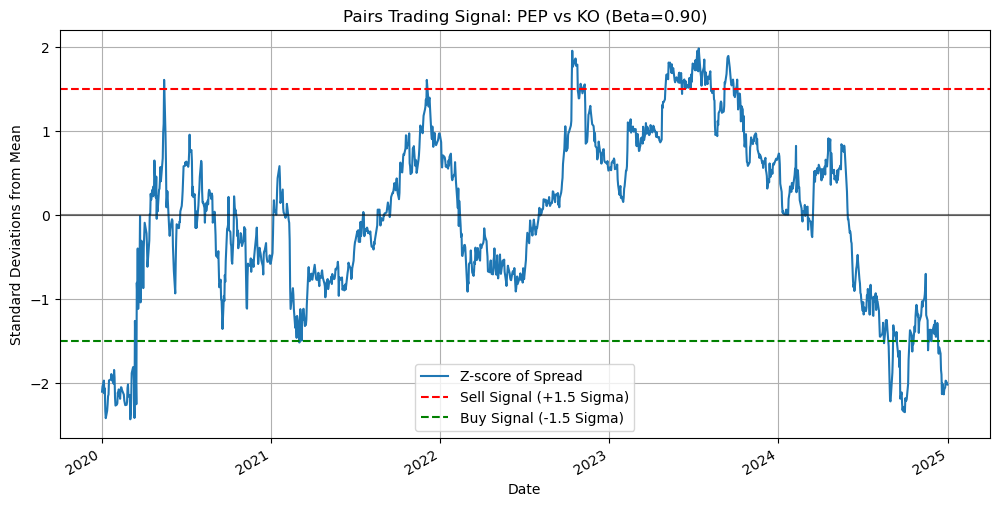

In [11]:
plt.figure(figsize=(12,6))
z_score.plot(label='Z-score of Spread')
plt.axhline(z_score.mean(), color='black', alpha=0.5)
plt.axhline(1.5, color='red', linestyle='--', label='Sell Signal (+1.5 Sigma)')
plt.axhline(-1.5, color='green', linestyle='--', label='Buy Signal (-1.5 Sigma)')
plt.title(f"Pairs Trading Signal: PEP vs KO (Beta={beta:.2f})")
plt.legend()
plt.ylabel("Standard Deviations from Mean")
plt.grid(True)
#plt.savefig("Figure_1_Pairs_Trading_Signal(PEP_vs_KO).png", dpi=300, bbox_inches='tight')
plt.show()

## XOM vs CVX

[*********************100%***********************]  2 of 2 completed

Estimated Hedge Ratio (Beta): 1.3866
This implies: To maintain a market-neutral position, for every long position in 1 unit of XOM, 
short 1.3866 units of CVX.

========== ADF Test Results ==========
ADF Statistic: -2.9435
P-value: 0.040515
Critical Values:
	1%: -3.4356
	5%: -2.8639
	10%: -2.5680


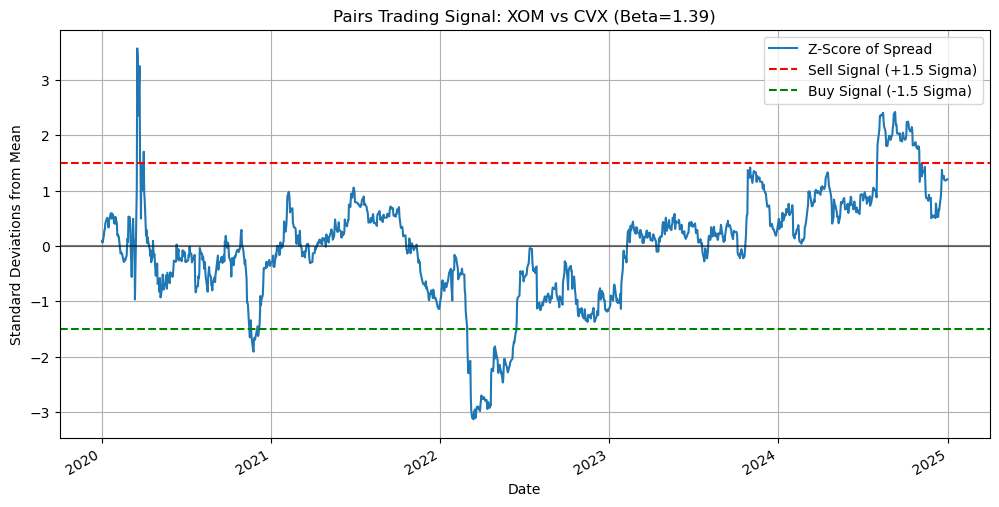

In [12]:
# 1. Retrieve historical data for the two companies (from 2020 onward to encompass multiple market cycles)
tickers = ['XOM', 'CVX']
data = yf.download(tickers, start="2020-01-01", end="2025-01-01")['Close']

# 2. Key mathematical consideration: Use logarithmic prices, as differences correspond to return ratios
S1 = np.log(data['XOM'])  # Dependent variable (Y)
S2 = np.log(data['CVX'])  # Independent variable (X)

# 3. Compute the hedge ratio using ordinary least squares (OLS) regression
# Model: log(XOM) = alpha + beta * log(CVX) + residual
# The residual represents the tradable spread
X = sm.add_constant(S2) # Add intercept term
model = sm.OLS(S1, X)
results = model.fit()
beta = results.params['CVX'] # Estimated beta coefficient

print(f"Estimated Hedge Ratio (Beta): {beta:.4f}")
print(f"This implies: To maintain a market-neutral position, for every long position in 1 unit of XOM, ")
print(f"short {beta:.4f} units of CVX.")

# 4. Construct the spread series (residuals)
# Spread = log(XOM) - beta * log(CVX) - alpha
spread = S1 - beta * S2 - results.params['const']

# 5. Stationarity test: Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(spread)
print("\n========== ADF Test Results ==========")
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"P-value: {adf_result[1]:.6f}")
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"\t{key}: {value:.4f}")

# 6. Visualization: Standardized Z-Score of the spread
# Focus on deviations from the mean in terms of standard deviations
z_score = (spread - spread.mean()) / spread.std()

plt.figure(figsize=(12, 6))
z_score.plot(label='Z-Score of Spread')
plt.axhline(z_score.mean(), color='black', alpha=0.5)
plt.axhline(1.5, color='red', linestyle='--', label='Sell Signal (+1.5 Sigma)')
plt.axhline(-1.5, color='green', linestyle='--', label='Buy Signal (-1.5 Sigma)')
plt.title(f"Pairs Trading Signal: XOM vs CVX (Beta={beta:.2f})")
plt.legend()
plt.ylabel("Standard Deviations from Mean")
plt.grid(True)
#plt.savefig("Figure_2_Pairs_Trading_Signal(XOM_vs_CVX).png", dpi=300, bbox_inches='tight')
plt.show()

## Vectorized Backtest

* **Open Position**: Enter a short position (sell to open) when the Z-Score exceeds 1.5; enter a long position (buy to open) when the Z-Score falls below -1.5.
* **Close Position**: Exit the position when the Z-Score reverts toward zero (mean reversion).
* **Stop Loss**: (To prevent forced liquidation) This scenario assumes no stop-loss mechanism is applied, with the position held until the end of the period (for illustrative purposes only).

In [13]:
# 1. Define Signal
entry_threshold = 1.5
exit_threshold = 0.5

# initialization of signal container
data_signal = pd.DataFrame(index=data.index)
data_signal['Z-Score'] = z_score
data_signal['Position'] = 0 # 1 for hold a long position of spread, -1 for hold short

In [14]:
# 2. Logic of trading
# Logic flow: State machine of position
current_position = 0
positions = []

for z in data_signal["Z-Score"]:
    if current_position == 0:
        # Flat position: look for open position
        if z > entry_threshold:
            current_position = -1 # Short position
        elif z < -exit_threshold:
            current_position = 1 # Long position
    elif current_position == -1:
        # Short position: look for close position
        if z < exit_threshold: # Back to normal
            current_position = 0
        # if z > 3.0: # Stop Loss
        #     current_position = 0
    elif current_position == 1:
        # Long position: look for close position
        if z > -exit_threshold: # Back to normal
            current_position = 0

    positions.append(current_position)

data_signal["Position"] = positions

In [15]:
# 3. Calculate Daily PnL of Spread [(Variation of Spread) * Position Direction]
# Spread is Log Delta of price. 
# Difference of Spread approximates the return ratio
data_signal['Spread_Change'] = spread.diff()
data_signal['Strategy_PnL'] = data_signal["Position"].shift(1) * data_signal['Spread_Change']

In [16]:
# 4. Cumulative Return
data_signal['Cumulative_PnL'] = data_signal["Strategy_PnL"].cumsum()

In [17]:
data_signal

,Z-Score,Position,Spread_Change,Strategy_PnL,Cumulative_PnL
Date,,,,,
2020-01-02,0.093267,0,NaN,NaN,NaN
2020-01-03,0.059293,0,-0.003268,-0.000000,0.000000
2020-01-06,0.187721,0,0.012355,0.000000,0.000000
2020-01-07,0.287536,0,0.009602,0.000000,0.000000
2020-01-08,0.295173,0,0.000735,0.000000,0.000000
...,...,...,...,...,...
2024-12-24,1.188689,-1,-0.007472,0.007472,1.092089
2024-12-26,1.183455,-1,-0.000503,0.000503,1.092592
2024-12-27,1.180477,-1,-0.000287,0.000287,1.092878


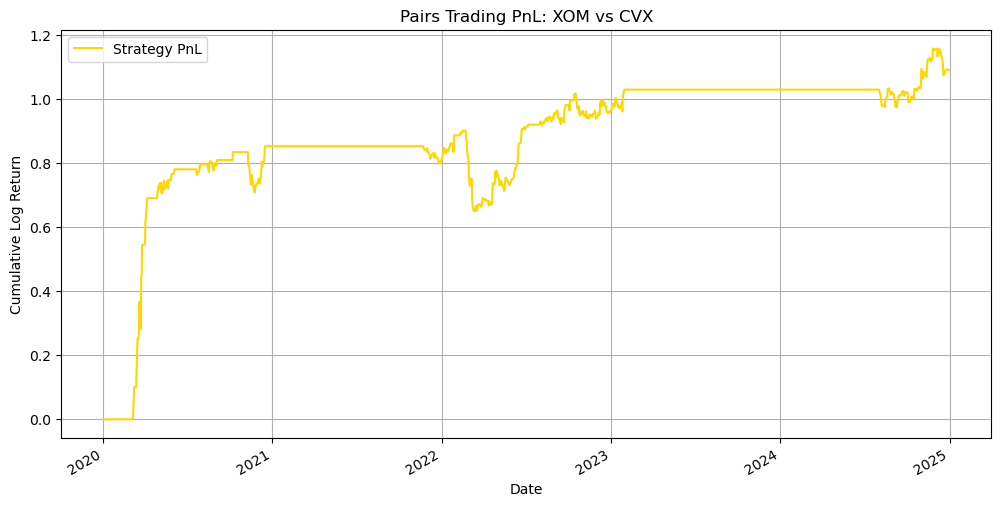

In [18]:
# 5. Visualiztion: Determine if profit is positive
plt.figure(figsize=(12,6))
data_signal['Cumulative_PnL'].plot(color='gold', label="Strategy PnL")
plt.title("Pairs Trading PnL: XOM vs CVX")
plt.xlabel("Date")
plt.ylabel("Cumulative Log Return")
plt.legend()
plt.grid(True)
#plt.savefig("Figure_3_Pair_Trading_PnL_XOM_vs_CVX.png", dpi=300, bbox_inches="tight")
plt.show()

In [19]:
# Print final results
total_return = data_signal['Cumulative_PnL'].iloc[-1]
print(f"Five-year total return(Log Return): {total_return:.4f}")

Five-year total return(Log Return): 1.0908


In [20]:
if total_return > 0:
    print("Math finally won, but it not a happy journey!")
else:
    print("Market taught me a bitter lesson!")

Math finally won, but it not a happy journey!
